In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import metrics 
import tqdm

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [2]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [3]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v2_annot.h5ad')
adata

CPU times: user 170 ms, sys: 152 ms, total: 322 ms
Wall time: 320 ms


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

## cluster level profiles

In [4]:
Xk, xclsts = basicu.group_mean(adata.X, adata.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=adata.var.index)
Xk.shape, xclsts.shape, xclsts

((6, 86),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

### classsification based off the ~86 genes (Try LASSO for the minimum set of genes)
- L2/3 vs L4
- L2/3 subtypes
- continuum (UMAP_1 as a proxy)

In [5]:
def get_precision_recall(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    p, r, th = metrics.precision_recall_curve(y_true, y_pred)
    # pidx = np.argsort(p)
    # p = p[pidx]
    # r = r[pidx]
    # p = np.hstack([0, p, 1])
    # r = np.hstack([1, r, 0])
    return p, r

def get_precision_recall_v2(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    pth = np.linspace(0,1,101)
    p = []
    r = []
    for pth1 in pth:
        conf = metrics.confusion_matrix(y_true, y_pred>pth)
        tn, fp, fn, tp = conf.ravel()
        p1 = tp/(tp+fp)
        r1 = tp/(tp+fn)
        p.append(p1)
        r.append(r1)
    
    return p, r

def evaluate(y_true, y_pred, pr_opt='v1'):
    """
    """
    # evaluation
    if pr_opt == 'v1':
        p, r = get_precision_recall(y_true, y_pred)
    elif pr_opt == 'v2':
        p, r = get_precision_recall_v2(y_true, y_pred)
    aupr = metrics.auc(r, p)
    # aupr = -1
    return p, r, aupr

def classifier_pipe(X, y, c=1):
    """
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    ps = []
    rs = []
    auprs = []
    
    y_true = np.empty(len(y))
    y_pred = np.empty(len(y))
    
    
    l0s = []
    l1s = []
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
        # model = LogisticRegression(random_state=0)
        model.fit(X_train, y_train)
        
        # test
        yp = model.predict_proba(X_test)
        
        # results
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
        
        # results
        y_true[test_idx] = y_test.values.astype(int)
        y_pred[test_idx] = yp[:,1]
        
        
    return y_true, y_pred, l0s, l1s

def plot_pipe(ax, y_true, y_pred, pr_opt='v1'):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, color='C0', linewidth=2)
    ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

In [8]:
def regression_pipe(X, y, alpha):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # build model
        model = Lasso(alpha=alpha, random_state=0)
        # train
        model.fit(X_train, y_train)
        # test
        yp = model.predict(X_test)
        # evaluation
        mse = np.power(yp-y_test, 2).mean()
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()

        # add
        l0s.append(l0)
        l1s.append(l1)
        mse_s.append(mse)
        
        ygs[test_idx] = y_test
        yps[test_idx] = yp
    
    return ygs, yps, mse_s, l0s, l1s

def tuning_regression(X, y, alphas):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
        res.append((ygs, yps, mse_s, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': np.mean(mse_s),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

In [7]:
def get_r2(y, yhat):
    """
    """
    r2 = 1-np.power(y-yhat, 2).sum()/np.power(y-np.mean(y), 2).sum()
    return r2

def get_mse(y, yhat):
    """
    """
    mse = np.power(y-yhat, 2).mean()
    return mse
    
def get_pearsonr(y, yhat):
    """
    """
    r, p = stats.pearsonr(y, yhat)
    return r

In [8]:
def regression_pipe(X, y, alpha):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # build model
        model = Lasso(alpha=alpha, random_state=0)
        # train
        model.fit(X_train, y_train)
        # test
        yp = model.predict(X_test)
        # evaluation
        mse = np.power(yp-y_test, 2).mean()
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()

        # add
        l0s.append(l0)
        l1s.append(l1)
        mse_s.append(mse)
        
        ygs[test_idx] = y_test
        yps[test_idx] = yp
    
    return ygs, yps, mse_s, l0s, l1s

def tuning_regression(X, y, alphas):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
        res.append((ygs, yps, mse_s, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': np.mean(mse_s),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

In [9]:
def get_model_used_genes(model, allgenes):
    """
    """
    abscoef = np.abs(model.coef_.reshape(-1,))
    cond = abscoef > 1e-6 
    
    if cond.sum() > 0:
        used_abscoef = abscoef[cond]
        used_genes = allgenes[cond]
        used_coefidx = np.argsort(used_abscoef)[::-1]

        return used_abscoef[used_coefidx], used_genes[used_coefidx]
    else:
        return 0,0

In [10]:
def plot_heatmap(Xplot, df0, xlabel='', title='', figsize=(8,5)):
    """
    """
    Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

    mosaic = "A"*10+"BCDE"
    fig, axs = plt.subplot_mosaic(mosaic, figsize=figsize)
    ax = axs['A']
    sns.heatmap(Xplot, 
                xticklabels=True,
                yticklabels=True,
                cmap='coolwarm', 
                cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
                ax=ax)
    ax.axvline(3, color='gray', linewidth=1)
    ax.set_yticklabels(ax.get_yticklabels(), 
                       # fontsize=10, 
                       rotation=0)
    ax.set_xlabel(xlabel)

    for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
        nums, catgs = pd.factorize(Xannot.iloc[:,i])
        # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
        sns.heatmap(nums.reshape(-1,1), 
                    annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                    annot_kws={'size': 10},
                    yticklabels=False,
                    # xticklabels=False,
                    fmt='',
                    cbar=False,
                    cmap='jet',
                    ax=ax
                   )
        ax.set_xticklabels([Xannot.columns[i]], rotation=90)
    fig.suptitle(title)
    plt.show()

In [11]:
def identify_used_genes_pipe(adata, col, cluster, model):
    """
    """
    # data
    X = adata.X
    if len(cluster) > 0:
        y = adata.obs[col].str.contains(cluster)
    else:
        y = adata.obs[col].values
        
    allgenes = adata.var.index.values

    model.fit(X, y)
    absweights, ugenes = get_model_used_genes(model, allgenes)
    print(len(ugenes), absweights, ugenes)
    return absweights, ugenes

In [12]:
# L2/3 and L4 adata
# subset L2/3 only
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()

# classification
# run L2/3 vs L4
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.001, random_state=0)
absweights, ugenes_l23vsl4 = identify_used_genes_pipe(adata, 'cluster', 'L2/3', model)

# run L2/3 subtypes
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.04, random_state=0)
absweights, ugenes_l23a = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_A', model)

model = LogisticRegression(penalty='l1', solver='liblinear', C=0.02, random_state=0)
absweights, ugenes_l23b = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_B', model)

model = LogisticRegression(penalty='l1', solver='liblinear', C=0.02, random_state=0)
absweights, ugenes_l23c = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_C', model)

4 [0.78910552 0.24077043 0.1638342  0.10520481] ['Gria3' 'Chrm3' 'Dgkb' 'Ncam2']
21 [0.73940487 0.66403692 0.55464718 0.42151191 0.32043887 0.18376898
 0.17992303 0.15818472 0.12460167 0.12402343 0.11175973 0.07761173
 0.07401739 0.06575897 0.05451651 0.02827839 0.02325866 0.01901836
 0.00961325 0.00874502 0.00816224] ['Cdh13' 'Cdh12' 'Cntn5' 'Sorcs3' 'Adamts2' 'Kcnq5' 'Nr4a3' 'Igfn1'
 'Stard8' 'Epha10' 'Mkx' 'Trpc6' 'Kcnh5' 'Cbln2' 'Kcnn3' 'Fst' 'Tenm1'
 'Robo1' 'Baz1a' 'Met' 'Ptpru']
22 [0.82028952 0.78245884 0.442525   0.40565408 0.37276156 0.33625554
 0.29142572 0.22935304 0.21186073 0.19708548 0.19588907 0.17204319
 0.16855667 0.11050752 0.10241661 0.08978417 0.06911582 0.06188946
 0.04942794 0.02963351 0.02530976 0.01943542] ['Chrm2' 'Cdh13' 'Sorcs3' 'Ncam2' 'Rorb' 'Kcnip3' 'Gabrg3' 'Igfn1' 'Sox5'
 'Dgkb' 'Cntnap2' 'Pcdh15' 'Grm8' 'Adamts2' 'Cdh12' 'Pld5' 'Gpc6' 'Trpc6'
 'Egfem1' 'Stard8' 'Fst' 'Epha3']
19 [0.79192976 0.73731547 0.60384274 0.45239422 0.43362829 0.42728683
 0.2339

In [13]:
# regression
# run L2/3 vs L4
model = Lasso(alpha=0.1, random_state=0)
absweights, ugenes_continous_l234 = identify_used_genes_pipe(adata, 'embed_1', '', model)

# run L2/3 subtypes
model = Lasso(alpha=0.1, random_state=0)
absweights, ugenes_continous_l23 = identify_used_genes_pipe(adatasub, 'embed_1', '', model)

40 [0.56846726 0.5083247  0.440899   0.41499802 0.4128907  0.33314303
 0.29864034 0.29675484 0.29098246 0.25831914 0.22854991 0.20758867
 0.19378401 0.16243175 0.14960524 0.13643067 0.13521126 0.11227936
 0.11188324 0.11144242 0.10888644 0.09443807 0.09031275 0.08649872
 0.08137737 0.08128972 0.07876988 0.07491864 0.07312207 0.07202394
 0.06813988 0.06386348 0.06065274 0.0571509  0.05205857 0.03920941
 0.02561827 0.01776213 0.01238846 0.00286121] ['Agmat' 'Cntn5' 'Rorb' 'Pcdh15' 'Chrm3' 'Ncam2' 'Meis2' 'Cux1' 'Dscaml1'
 'Ngb' 'Whrn' 'Grm1' 'Dgkb' 'Gabrg3' 'Otof' 'S100a6' 'Ccbe1' 'Tenm1'
 'Rfx3' 'Kcnip3' 'Fst' 'Igsf11' 'Epha3' 'Kcnn3' 'Sorcs3' 'Cbr3' 'Coch'
 'Stard8' 'Mdga1' 'Gria3' 'Ntng1' 'Kcnh5' 'Plxnd1' 'Gpc6' 'Adamts2' 'Mkx'
 'Cdh20' 'Pld5' 'Penk' 'Trpc6']
34 [0.45666492 0.20064823 0.18226762 0.17345765 0.13298462 0.12929662
 0.11031938 0.11022168 0.10806664 0.10711033 0.10572949 0.09851377
 0.09844457 0.09703507 0.08904256 0.08840228 0.08689899 0.08664139
 0.08658852 0.08100744 0.

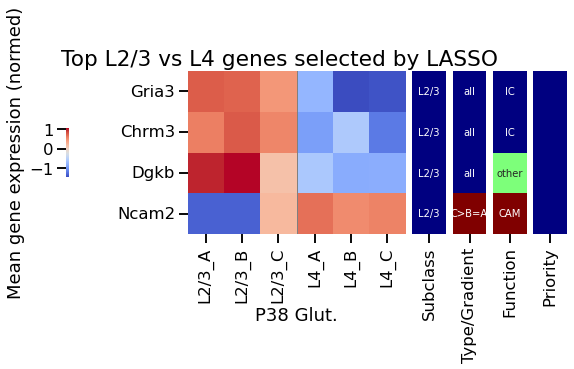

In [14]:
plot_heatmap(Xk.T.loc[ugenes_l23vsl4], 
             df0,
             figsize=(10,3),
             xlabel='P38 Glut.', 
             title='Top L2/3 vs L4 genes selected by LASSO',
            )

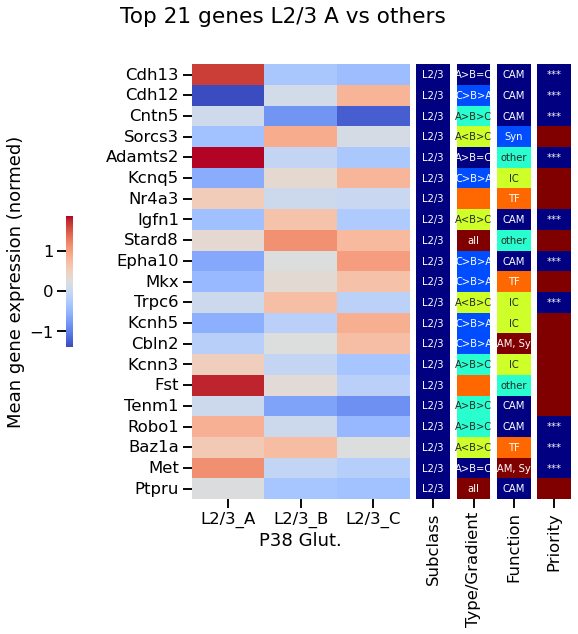

In [15]:
plot_heatmap(Xk.T.loc[ugenes_l23a, ['L2/3_A', 'L2/3_B', 'L2/3_C']], 
             df0,
             figsize=(10,8),
             xlabel='P38 Glut.', 
             title=f'Top {len(ugenes_l23a)} genes L2/3 A vs others',
            )

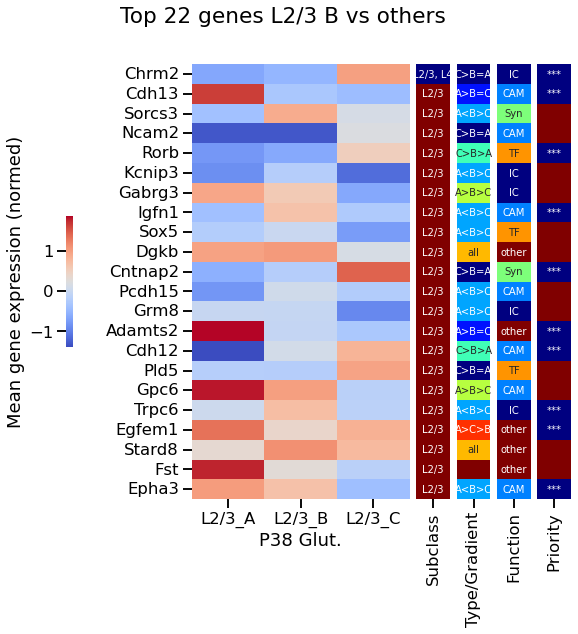

In [17]:
plot_heatmap(Xk.T.loc[ugenes_l23b, ['L2/3_A', 'L2/3_B', 'L2/3_C']], 
             df0,
             figsize=(10,8),
             xlabel='P38 Glut.', 
             title=f'Top {len(ugenes_l23b)} genes L2/3 B vs others',
            )

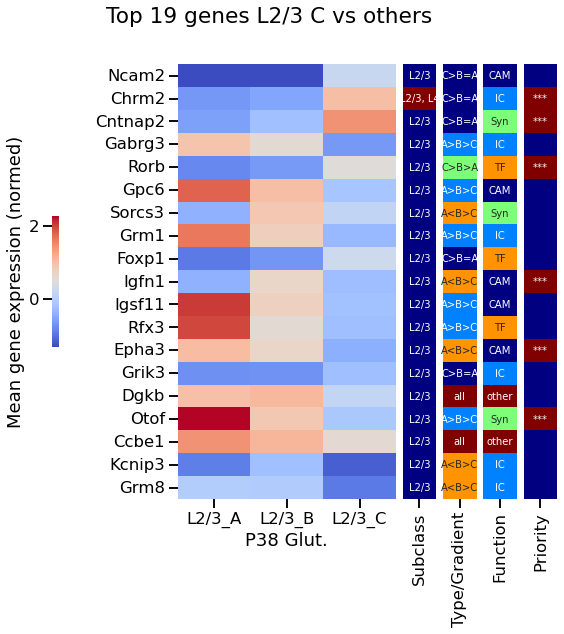

In [18]:
plot_heatmap(Xk.T.loc[ugenes_l23c, ['L2/3_A', 'L2/3_B', 'L2/3_C']], 
             df0,
             figsize=(10,8),
             xlabel='P38 Glut.', 
             title=f'Top {len(ugenes_l23c)} genes L2/3 C vs others',
            )

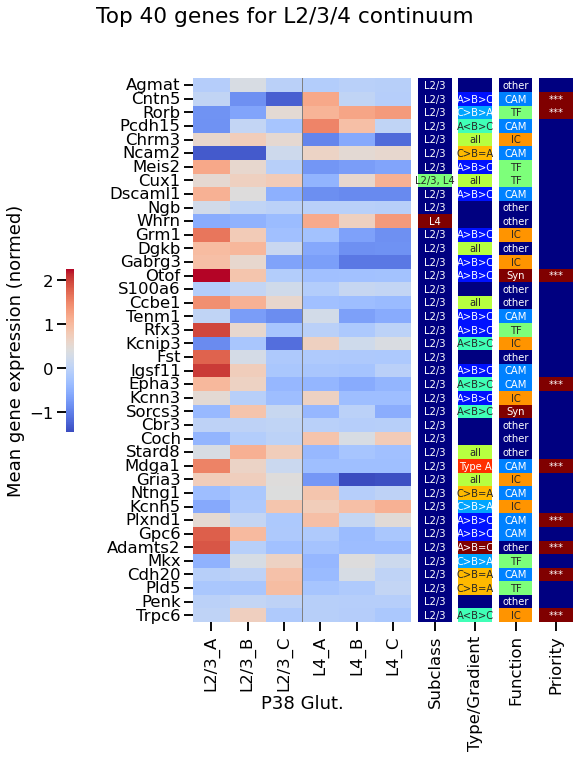

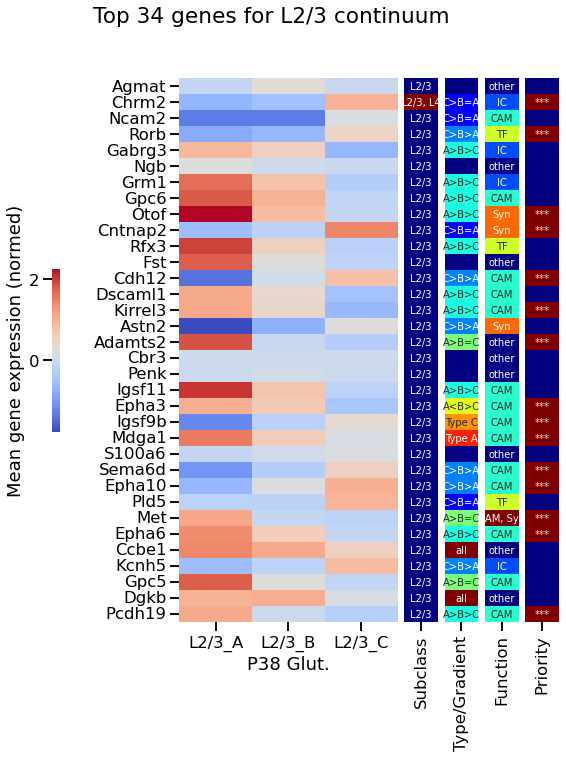

In [19]:
plot_heatmap(Xk.T.loc[ugenes_continous_l234], 
             df0,
             figsize=(10,10),
             xlabel='P38 Glut.', 
             title=f'Top {len(ugenes_continous_l234)} genes for L2/3/4 continuum',
            )

plot_heatmap(Xk.T.loc[ugenes_continous_l23, ['L2/3_A', 'L2/3_B', 'L2/3_C']], 
             df0,
             figsize=(10,10),
             xlabel='P38 Glut.', 
             title=f'Top {len(ugenes_continous_l23)} genes for L2/3 continuum',
            )

In [37]:
Xannot_all = Xk.T.copy()
Xannot_all.loc[ugenes_l23vsl4, 'LassoRank_L23vsL4'] = 1+np.arange(len(ugenes_l23vsl4))
Xannot_all.loc[ugenes_l23a, 'LassoRank_L23a'] = 1+np.arange(len(ugenes_l23a))
Xannot_all.loc[ugenes_l23b, 'LassoRank_L23b'] = 1+np.arange(len(ugenes_l23b))
Xannot_all.loc[ugenes_l23c, 'LassoRank_L23c'] = 1+np.arange(len(ugenes_l23c))

Xannot_all.loc[ugenes_continous_l234, 'LassoRank_L234continuum'] = 1+np.arange(len(ugenes_continous_l234))
Xannot_all.loc[ugenes_continous_l23, 'LassoRank_L23continuum'] = 1+np.arange(len(ugenes_continous_l23))
Xannot_all

,L2/3_A,L2/3_B,L2/3_C,L4_A,L4_B,L4_C,LassoRank_L23vsL4,LassoRank_L23a,LassoRank_L23b,LassoRank_L23c,LassoRank_L234continuum,LassoRank_L23continuum
Adamts2,1.858016,-0.053456,-0.295377,-0.267231,-0.346460,-0.343735,NaN,5.0,14.0,NaN,35.0,17.0
Agmat,-0.094667,0.334063,-0.031858,-0.106670,-0.044044,-0.062609,NaN,NaN,NaN,NaN,1.0,1.0
Astn2,-1.755522,-0.724826,0.266386,-0.085457,0.472014,0.968893,NaN,NaN,NaN,NaN,NaN,16.0
Baz1a,0.573863,0.718998,0.228560,-0.247285,-0.245208,-0.257214,NaN,19.0,NaN,NaN,NaN,NaN
Bdnf,0.085807,0.427752,-0.020473,-0.163560,0.442058,0.122826,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Tbr1,-0.230443,-0.101686,0.210291,-0.248597,-0.000906,-0.037251,NaN,NaN,NaN,NaN,NaN,NaN
Tenm1,0.036886,-0.704994,-0.867177,0.261973,-0.685486,-0.571384,NaN,17.0,NaN,NaN,18.0,NaN
Trpc6,0.028524,0.711003,-0.151368,-0.066116,-0.085283,-0.187902,NaN,12.0,18.0,NaN,40.0,NaN
Whrn,-0.542949,-0.482650,-0.360417,1.166616,0.696177,1.322210,NaN,NaN,NaN,NaN,11.0,NaN


In [40]:
Xannot_all.sort_values('LassoRank_L234continuum')
Xannot_all.sort_values('LassoRank_L23continuum')

,L2/3_A,L2/3_B,L2/3_C,L4_A,L4_B,L4_C,LassoRank_L23vsL4,LassoRank_L23a,LassoRank_L23b,LassoRank_L23c,LassoRank_L234continuum,LassoRank_L23continuum
Agmat,-0.094667,0.334063,-0.031858,-0.106670,-0.044044,-0.062609,NaN,NaN,NaN,NaN,1.0,1.0
Chrm2,-0.668544,-0.519321,0.988498,0.057529,0.816239,0.824584,NaN,NaN,1.0,2.0,NaN,2.0
Ncam2,-1.313442,-1.312060,0.204138,0.648405,0.505193,0.557858,4.0,NaN,4.0,1.0,6.0,3.0
Rorb,-0.809482,-0.641019,0.502236,1.070327,1.222992,1.328093,NaN,NaN,5.0,5.0,3.0,4.0
Gabrg3,0.930508,0.562254,-0.651035,-0.693273,-1.057556,-1.059091,NaN,NaN,7.0,4.0,14.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Tbr1,-0.230443,-0.101686,0.210291,-0.248597,-0.000906,-0.037251,NaN,NaN,NaN,NaN,NaN,NaN
Tenm1,0.036886,-0.704994,-0.867177,0.261973,-0.685486,-0.571384,NaN,17.0,NaN,NaN,18.0,NaN
Trpc6,0.028524,0.711003,-0.151368,-0.066116,-0.085283,-0.187902,NaN,12.0,18.0,NaN,40.0,NaN
Whrn,-0.542949,-0.482650,-0.360417,1.166616,0.696177,1.322210,NaN,NaN,NaN,NaN,11.0,NaN


In [42]:
Xannot_all.to_csv("../data_dump/Lasso_summary_86genes_April15.csv", header=True, index=True)